In [45]:
# unrar
import shutil
from zipfile import ZipFile as zf

SEED = 101

with zf('Clinic.zip','r') as zin:
    zin.extractall()
    shutil.rmtree('25yjwbphn4-1')

In [46]:
# load data
import pandas as pd

df = pd.read_csv('Dataset.csv',encoding='utf-8')
medications = pd.read_csv('Medicationkey.csv')

df.rename(columns={'ID': 'Patient'}, inplace=True)
df.set_index('Patient',inplace=True)
medications.set_index('Medication', inplace=True)

# As-is, drug names have been shortened to alphabet letters, let's revert that
old_columns = medications.values.flatten()
new_columns = medications.index

for old, new in zip(old_columns, new_columns):
    df.rename(columns={old: new}, inplace=True)

In [47]:
# Get a sense of what features we are dealing with in this set
df.columns

Index(['GENDER', 'AGE', 'RACE/ETHNICITY', 'Diagnosis', 'MD', 'Assignment',
       'EMR', 'LOS', 'RAR', 'AMITRIPTYLINE', 'ARIPIPRAZOLE', 'ASENAPINE',
       'BUPROPION', 'CHLORPROMAZINE', 'CITALOPRAM', 'CLOMIPRAMINE',
       'CLONIDINE', 'DOXEPIN', 'DULOXETINE', 'ESCITALOPRAM', 'FLUOXETINE',
       'FLUPHENAZINE', 'FLUVOXAMINE', 'GUANFACINE', 'HALOPERIDOL',
       'IMIPRAMINE', 'LITHIUM CARBONATE', 'METHYLPHENIDATE', 'MIRTAZAPINE',
       'NORTRIPTYLINE', 'OLANZAPINE', 'PALIPERIDONE', 'PERPHENAZINE',
       'QUETIAPINE', 'RISPERIDONE', 'SERTRALINE', 'TRAZODONE', 'VENLAFAXINE',
       'ZIPRASIDONE', '# Psychotropic Medications', '# Administrations',
       'Therapeutic Guidances'],
      dtype='object')

In [48]:
# Clean unconventional column names
df.rename(columns={'# Administrations': 'Administrations'}, inplace=True)
df.rename(columns={'# Psychotropic Medications': 'Psychotropics'}, inplace=True)
df.rename(columns={'RACE/ETHNICITY': 'Ethnicity'}, inplace=True)

In [49]:
print('Checking for void values:')
df[df.columns[df.isnull().any()]].isnull().sum()

Checking for void values:


Assignment               41
Therapeutic Guidances    41
dtype: int64

In [6]:
'''
My strategy: 
Fill NaN with the most frequent value for each category
Note: mode() is the same as doing df[c].value_counts().index[0]
'''

df["Therapeutic Guidances"].mode().iloc[0]
df["Assignment"].fillna(df["Assignment"].mode().iloc[0], inplace=True)
df["Therapeutic Guidances"].fillna(df["Therapeutic Guidances"].mode().iloc[0], inplace=True)

In [7]:
df.groupby(['RAR']).count().transpose().head(1)

RAR,0,1
GENDER,1358,142


Discharged people : 1358 Recurrent people: 142 with a 9.56 imbalance


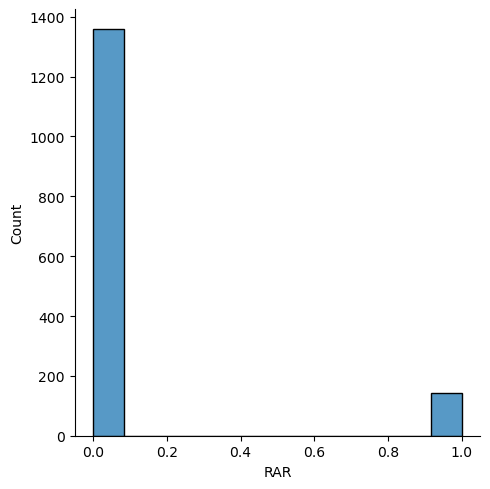

In [8]:
# Understanding data
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

discharged_ppl,recurrent_ppl = df['RAR'].value_counts()
imbalance_ratio = np.around(discharged_ppl / recurrent_ppl,2)
print(f'Discharged people : {discharged_ppl} Recurrent people: {recurrent_ppl} with a {imbalance_ratio} imbalance')
sns.displot(df['RAR'])

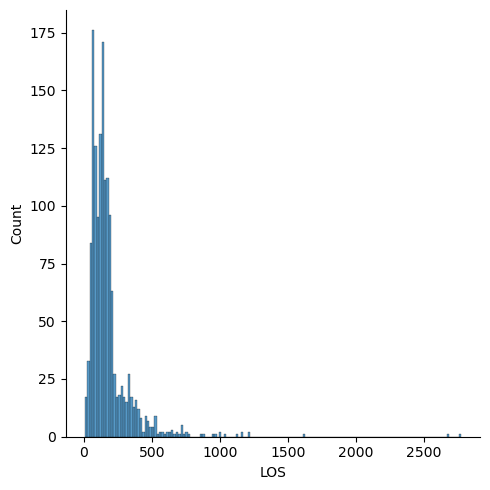

count    1500.000000
mean      176.520667
std       174.259930
min         6.000000
25%        90.000000
50%       138.000000
75%       191.250000
max      2776.000000
Name: LOS, dtype: float64


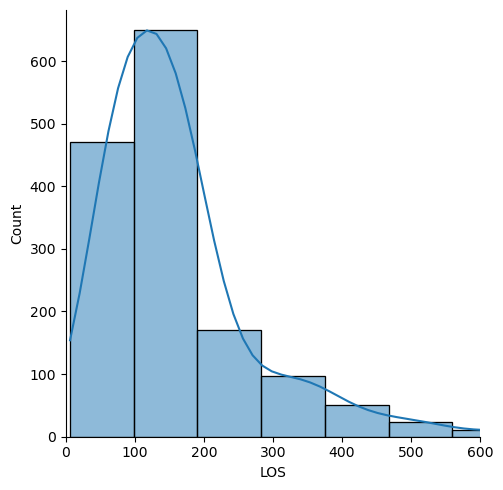

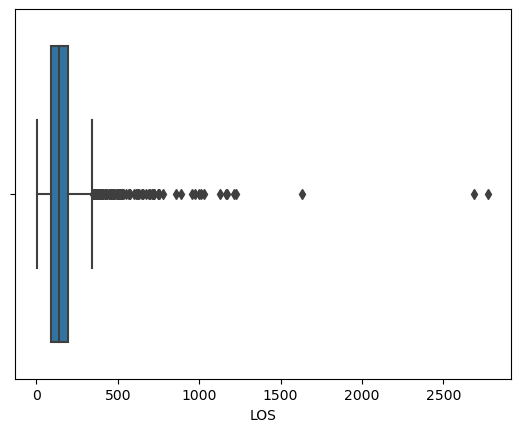

In [43]:
# Let's try to focus on another outcome

sns.displot(df['LOS'])
plt.show()
# Most patients don't stay more than 200 days
print(df['LOS'].describe())
sns.displot(data=df,x='LOS',bins=30,kde=1)
plt.xlim(0,600)
plt.show()
# Possibly detecting outliers
sns.boxplot(data=df,x='LOS')
plt.show()

<Axes: xlabel='Ethnicity', ylabel='LOS'>

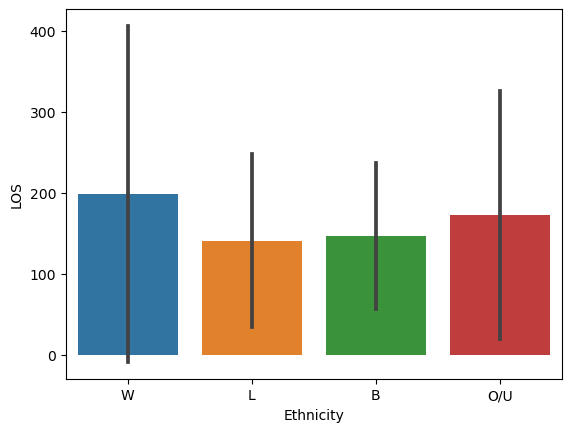

In [23]:
# White patients tend to vary most and have on avg the majority of LOS
sns.barplot(data=df, x='Ethnicity', y='LOS', estimator=np.mean, errorbar='sd')

<Axes: xlabel='LOS', ylabel='Administrations'>

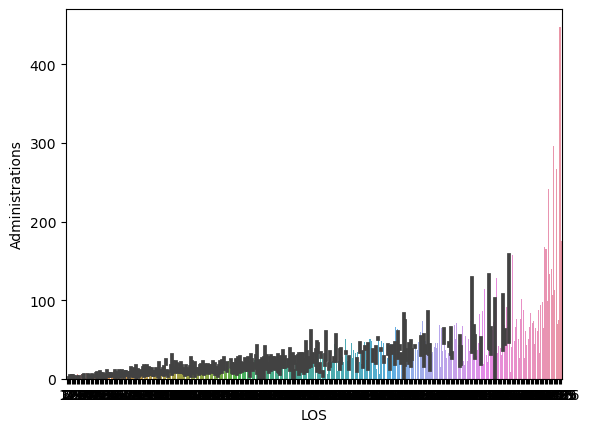

In [11]:
# Here we cannot see the number of people who fall into these ranges but rather only how total drug intake + days in clinic are  correlated
sns.barplot(data=df,x='LOS',y='Administrations')

C:\Users\W\AppData\Local\Temp\ipykernel_27660\495824401.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cols = df.corr().nlargest(26, 'LOS')['LOS'].sort_values(ascending=False).index


<Axes: >

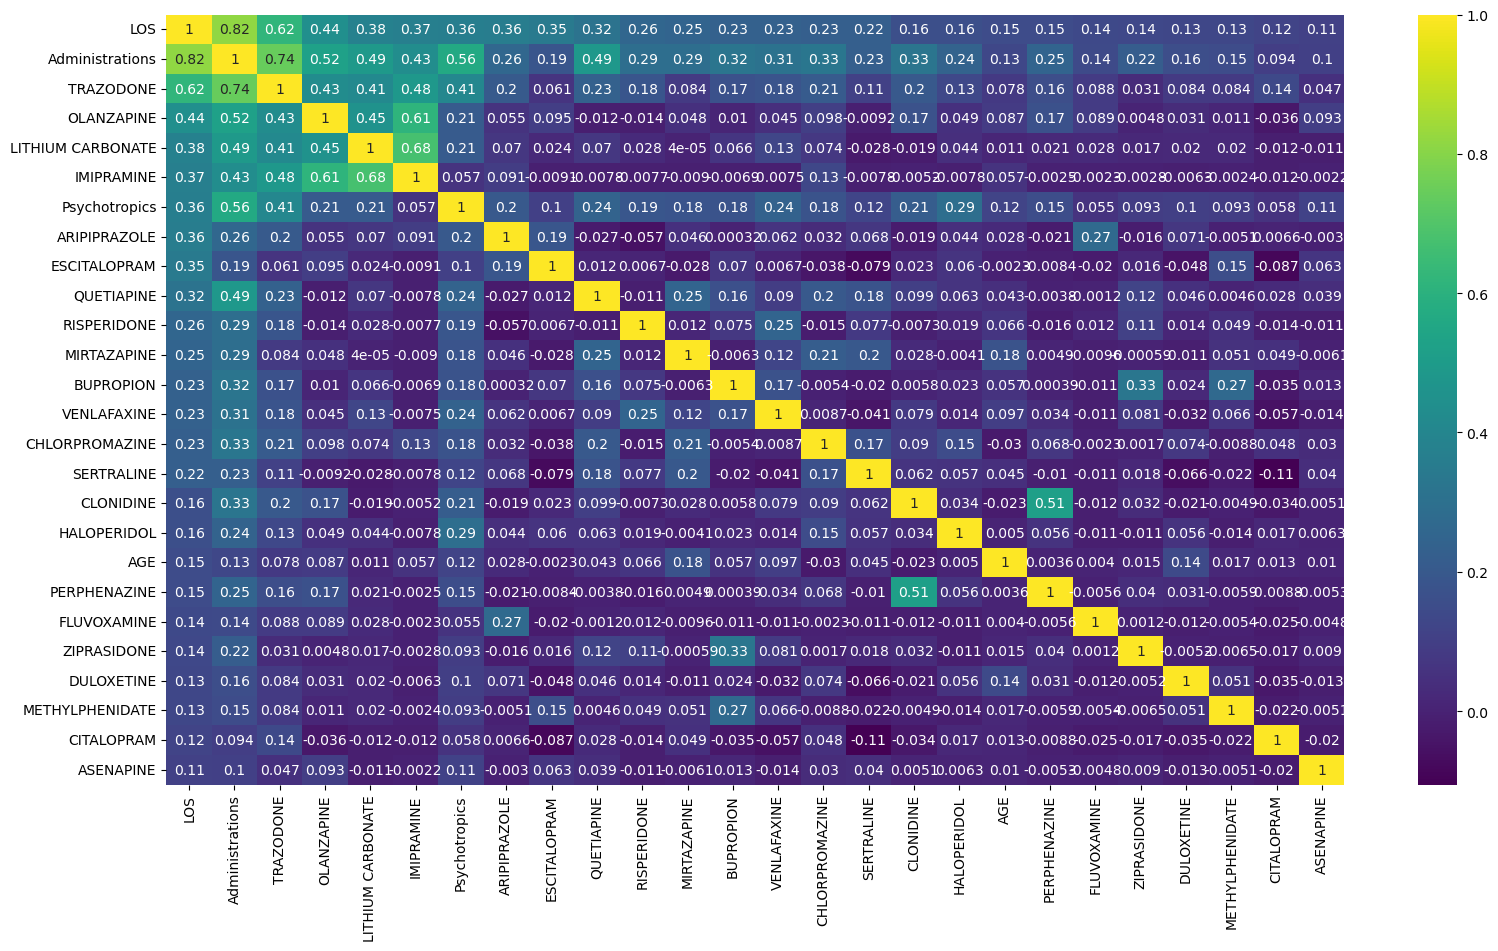

In [12]:
# There seems to be a correlation between the length of stay (LOS) and the amount of medications patients had to take
# Let's corroborate that presumption by plotting a heatmap!
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(19,10),dpi=100)
cols = df.corr().nlargest(26, 'LOS')['LOS'].sort_values(ascending=False).index
sns.heatmap(df[cols].corr(),annot=True,cmap='viridis')

In [13]:
# Too many features, isn't it? 

def clean_useless_cols(df, y_label):
    print('#########################')
    print(f'starting with {df.columns.size} cols')
    print('#########################')
    print(df.corr().nlargest(df.columns.size, y_label)
          [y_label].sort_values(ascending=True))
    irrelevant_cols = pd.DataFrame(df.corr()[y_label]).isna()
    ir_cols_list = irrelevant_cols[irrelevant_cols[y_label]].index
    print('\n#########################')
    print('irrelevant cols found (constants):')
    print('#########################')
    print(df[ir_cols_list].nunique())
    df.drop(ir_cols_list, axis=1, inplace=True)
    print('\n#########################')
    print(f'voila! set cleared. {df.columns.size} cols left to work with')
    print('#########################')

clean_useless_cols(df,'LOS')

#########################
starting with 42 cols
#########################
GUANFACINE           0.001724
PALIPERIDONE         0.024403
NORTRIPTYLINE        0.026556
FLUPHENAZINE         0.029459
AMITRIPTYLINE        0.036447
RAR                  0.041336
CLOMIPRAMINE         0.047341
FLUOXETINE           0.082462
DOXEPIN              0.087144
ASENAPINE            0.106835
CITALOPRAM           0.116268
METHYLPHENIDATE      0.129360
DULOXETINE           0.131695
ZIPRASIDONE          0.135403
FLUVOXAMINE          0.137158
PERPHENAZINE         0.145510
AGE                  0.147532
HALOPERIDOL          0.161150
CLONIDINE            0.161729
SERTRALINE           0.224537
CHLORPROMAZINE       0.226388
VENLAFAXINE          0.231670
BUPROPION            0.234516
MIRTAZAPINE          0.247004
RISPERIDONE          0.257082
QUETIAPINE           0.316571
ESCITALOPRAM         0.345968
ARIPIPRAZOLE         0.358304
Psychotropics        0.362663
IMIPRAMINE           0.368087
LITHIUM CARBONATE    0.377

C:\Users\W\AppData\Local\Temp\ipykernel_27660\691254445.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.corr().nlargest(df.columns.size, y_label)
C:\Users\W\AppData\Local\Temp\ipykernel_27660\691254445.py:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  irrelevant_cols = pd.DataFrame(df.corr()[y_label]).isna()


# WIP

In [14]:
# Let's get our hands dirty
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, chi2, RFE,RFECV
from sklearn.model_selection import train_test_split

clf = DecisionTreeClassifier(random_state=101)
OG_X = df.drop('LOS', axis=1)
# ????
alternative_x_vraag = OG_X.select_dtypes('number')

DummyX = pd.get_dummies(OG_X,drop_first=True)
y = df['LOS']

# Error encountered! 
# The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
# X_train, X_test, y_train, y_test = train_test_split(
#     OG_X, y, random_state=101, shuffle=1, test_size=0.3, stratify=y)

# TODO Solution: Combine values so you don't end up with single datapoints for very similar ranges

In [15]:
# test...

from sklearn.linear_model import ElasticNetCV

DummyX.columns
# TODO continue cleaning OR feed to ensemble / nn

Index(['AGE', 'RAR', 'AMITRIPTYLINE', 'ARIPIPRAZOLE', 'ASENAPINE', 'BUPROPION',
       'CHLORPROMAZINE', 'CITALOPRAM', 'CLOMIPRAMINE', 'CLONIDINE', 'DOXEPIN',
       'DULOXETINE', 'ESCITALOPRAM', 'FLUOXETINE', 'FLUPHENAZINE',
       'FLUVOXAMINE', 'GUANFACINE', 'HALOPERIDOL', 'IMIPRAMINE',
       'LITHIUM CARBONATE', 'METHYLPHENIDATE', 'MIRTAZAPINE', 'NORTRIPTYLINE',
       'OLANZAPINE', 'PALIPERIDONE', 'PERPHENAZINE', 'QUETIAPINE',
       'RISPERIDONE', 'SERTRALINE', 'TRAZODONE', 'VENLAFAXINE', 'ZIPRASIDONE',
       'Psychotropics', 'Administrations', 'GENDER_M', 'RACE/ETHNICITY_L',
       'RACE/ETHNICITY_O/U', 'RACE/ETHNICITY_W',
       'Diagnosis_\tMDD, recurrent episode with anxious distress',
       'Diagnosis_Adjustment Disorder With Depressed Mood',
       'Diagnosis_Bipolar II Disorder', 'Diagnosis_Depression',
       'Diagnosis_Depression with suicidal ideation',
       'Diagnosis_Depressive Disorder NOS',
       'Diagnosis_Dissociative Disorder NOS', 'Diagnosis_MDD',
       '

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
# TODO Error Encoders require their input to be uniformly strings or numbers. Got ['int', 'str']
# XX = LabelEncoder().fit_transform(OG_X.to_numpy().reshape(-1,1))

In [17]:
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay

def acc_confusion(clf,X,y):
    print('#########################')
    print(f'accuracy: {accuracy_score(y,clf.predict(X))}')
    print('#########################')
    ConfusionMatrixDisplay.from_estimator(clf,X,y)

In [18]:
clf = DecisionTreeClassifier().fit(alternative_x_vraag,y)

# Vanilla
clf.score(alternative_x_vraag,y)

0.9626666666666667

In [ ]:
# Possible feature selection
# KBest
skb = SelectKBest(chi2, k=5).fit(X_train, y_train)
# Recurrent Feature Extraction 
rfe = RFE(clf,step=1).fit(X_train,y_train)
# Recurrent Feature Extraction with Cross-Validation
rfecv = RFECV(clf,step=1,scoring='accuracy',cv=5).fit(X_train,y_train)

SKBX_train = skb.transform(X_train)
SKBX_test = skb.transform(X_test)
pd.DataFrame({'ft': OG_X.columns, 'score': skb.scores_}
             ).sort_values('score', ascending=0)
print(f'SKB OG ft: {X_train.shape[1:]} | best ft: {SKBX_train.shape[1:]}')

RFEX_train = rfe.transform(X_train)
RFEX_test = rfe.transform(X_test)
rfe_df = pd.DataFrame({'ft':OG_X.columns,'ranking':rfe.ranking_}).sort_values('ranking')
keep_ft = rfe_df.loc[rfe_df['ranking']<2,'ranking'].count()
print(f'RFE now considering {keep_ft} cols')

RFECVX_train = rfecv.transform(X_train)
RFECVX_test = rfecv.transform(X_test)
print(f'RFECV says {X_train.columns[rfecv.support_]} ({rfecv.n_features_}) as best ft\'s to keep')